In [1]:
import cirq
import numpy as np

In [2]:
def int_to_Gray(base_10_num, n_qubits):
    # https://en.wikipedia.org/wiki/Gray_code

    # print(np.binary_repr(num, n_qubits)) # standard binary form!

    # The operator >> is shift right. The operator ^ is exclusive or
    gray_int = base_10_num ^ (base_10_num >> 1)

    return np.binary_repr(gray_int, n_qubits)

In [260]:
n_qubits=4

state_array = np.arange(0,2**n_qubits,1)
print(state_array)

grey_state=np.array([int_to_Gray(i, n_qubits) for i in state_array])
print(grey_state)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
['0000' '0001' '0011' '0010' '0110' '0111' '0101' '0100' '1100' '1101'
 '1111' '1110' '1010' '1011' '1001' '1000']


In [29]:
start_index = np.where(grey_state==''.join(['1' for _ in range(n_qubits)]))[0][0]

In [30]:
np.hstack((grey_state[start_index::], grey_state[:start_index]))

array(['111', '101', '100', '000', '001', '011', '010', '110'],
      dtype='<U3')

In [32]:
def control_circuit(n_ancilla_qubits): # list_system_qubits
    ancilla_qubits = list(cirq.LineQubit.range(n_ancilla_qubits))
    
    n_work_qubits = n_ancilla_qubits-1
    work_qubits = list(cirq.LineQubit.range(n_ancilla_qubits, n_work_qubits+n_ancilla_qubits))
    
    system_qubit = cirq.LineQubit(n_work_qubits+n_ancilla_qubits) #need to change this when doing properly!
    
    state_array = np.arange(0,2**n_ancilla_qubits,1)
    grey_state_array =np.array([int_to_Gray(i, n_ancilla_qubits) for i in state_array])
    
#     start_index = np.where(grey_state_array==''.join(['1' for _ in range(n_ancilla_qubits)]))[0][0] # find all '11...1' state
    
#     control_states_in_order = np.hstack((grey_state_array[start_index::], grey_state_array[:start_index]))
    control_states_in_order=grey_state_array
    
    control_circuit_list=[]
    for control_str in control_states_in_order:
        control_int_list = [int(bit) for bit in control_str]
#         print(control_int_list)
        circuit_list=[]
        for index, work_bit in enumerate(work_qubits):
            if index ==0:
                circuit_list.append(cirq.Circuit(cirq.X.controlled(num_controls=2,
                                               control_values=control_int_list[:2]
                                              ).on(*ancilla_qubits[:2], work_bit)))
                
            elif index<n_work_qubits-1:
                circuit_list.append(cirq.Circuit(cirq.X.controlled(num_controls=2,
                                               control_values= [control_int_list[1+index], 1] 
                                              ).on(ancilla_qubits[1+index], work_qubits[index-1], work_qubits[index])))
            else:
                circuit_list.append(cirq.Circuit(cirq.X.controlled(num_controls=2,
                                               control_values= [control_int_list[1+index], 1] 
                                              ).on(ancilla_qubits[1+index], work_qubits[index-1], work_qubits[index])))
        
        control_P = cirq.Circuit(cirq.Y.controlled(num_controls=1,
                                               control_values= [1] 
                                              ).on(work_qubits[-1], system_qubit))
        
        full_circuit=[circuit_list, control_P, circuit_list[::-1]]
        
#         print(cirq.Circuit(full_circuit))
#         print('')
        control_circuit_list.append(cirq.Circuit(full_circuit))
        
    return control_circuit_list
        

unsimplified_gate_seq = control_circuit(3)

In [33]:
unsimplified_gate_seq[0]

0: ───(0)───────────────────(0)───
      │                     │
1: ───(0)───────────────────(0)───
      │                     │
2: ───┼─────(0)───────(0)───┼─────
      │     │         │     │
3: ───X─────@─────────@─────X─────
            │         │
4: ─────────X─────@───X───────────
                  │
5: ───────────────Y───────────────

In [34]:
list(unsimplified_gate_seq[0].all_operations())[-1].gate
# list(unsimplified_gate_seq[0].all_operations())[-1].gate.sub_gate
# list(unsimplified_gate_seq[0].all_operations())[-1].qubits
# list(unsimplified_gate_seq[0].all_operations())[-1].control_values

cirq.ControlledGate(sub_gate=cirq.X, control_values=((0,), (0,)),control_qid_shape=(2, 2))

In [35]:
circuit_1_ops = list(unsimplified_gate_seq[0].all_operations())
circuit_2_ops = list(unsimplified_gate_seq[1].all_operations())
len(circuit_1_ops[0].control_values)

2

In [36]:
def recursive_simplification(circuit_1_ops, circuit_2_ops):
    if (circuit_1_ops[-1] == circuit_2_ops[0]) and (len(circuit_1_ops[-1].control_values)==2):
        circuit_1_ops.pop(-1)
        circuit_2_ops.pop(0)
        
        return recursive_simplification(circuit_1_ops, circuit_2_ops)
    else:
        return circuit_1_ops, circuit_2_ops
        
# circuit_1_ops = list(unsimplified_gate_seq[0].all_operations())
# circuit_2_ops = list(unsimplified_gate_seq[1].all_operations())
# c1, c2 = recursive_simplification(circuit_1_ops, circuit_2_ops)
# print(cirq.Circuit(c1))
# print(cirq.Circuit(c2))

In [37]:
simple_gate_cancel_list=unsimplified_gate_seq.copy()

for index in range(len(simple_gate_cancel_list)-1):
    circuit_1_ops = list(simple_gate_cancel_list[index].all_operations())
    circuit_2_ops = list(simple_gate_cancel_list[index+1].all_operations())
    c1_new, c2_new = recursive_simplification(circuit_1_ops, circuit_2_ops)
                                                                                               
    simple_gate_cancel_list[index] = cirq.Circuit(c1_new)
    simple_gate_cancel_list[index+1] = cirq.Circuit(c2_new)
    
simple_gate_cancel_list

[0: ───(0)───────────────────
      │
1: ───(0)───────────────────
      │
2: ───┼─────(0)───────(0)───
      │     │         │
3: ───X─────@─────────@─────
            │         │
4: ─────────X─────@───X─────
                  │
5: ───────────────Y─────────,
 0: ───────────────(0)───
                  │
1: ───────────────(0)───
                  │
2: ───@───────@───┼─────
      │       │   │
3: ───@───────@───X─────
      │       │
4: ───X───@───X─────────
          │
5: ───────Y─────────────,
 0: ───(0)───────────────
      │
1: ───@─────────────────
      │
2: ───┼─────@───────@───
      │     │       │
3: ───X─────@───────@───
            │       │
4: ─────────X───@───X───
                │
5: ─────────────Y───────,
 0: ───────────────────(0)───
                      │
1: ───────────────────@─────
                      │
2: ───(0)───────(0)───┼─────
      │         │     │
3: ───@─────────@─────X─────
      │         │
4: ───X─────@───X───────────
            │
5: ─────────Y───────

In [38]:
def cancel_double_T_gates(list_of_Q_circuits):
    # takes in list of circuits and simplifies repeated Toffoli gates 
    simplified_circuit_list=list_of_Q_circuits.copy()
    for index in range(len(simplified_circuit_list)-1):
        circuit_1_ops = list(simplified_circuit_list[index].all_operations())
        circuit_2_ops = list(simplified_circuit_list[index+1].all_operations())
        c1_new, c2_new = recursive_simplification(circuit_1_ops, circuit_2_ops)

        simplified_circuit_list[index] = cirq.Circuit(c1_new)
        simplified_circuit_list[index+1] = cirq.Circuit(c2_new)
    return simplified_circuit_list
simple_gate_cancel_list=cancel_double_T_gates(unsimplified_gate_seq)
simple_gate_cancel_list

[0: ───(0)───────────────────
      │
1: ───(0)───────────────────
      │
2: ───┼─────(0)───────(0)───
      │     │         │
3: ───X─────@─────────@─────
            │         │
4: ─────────X─────@───X─────
                  │
5: ───────────────Y─────────,
 0: ───────────────(0)───
                  │
1: ───────────────(0)───
                  │
2: ───@───────@───┼─────
      │       │   │
3: ───@───────@───X─────
      │       │
4: ───X───@───X─────────
          │
5: ───────Y─────────────,
 0: ───(0)───────────────
      │
1: ───@─────────────────
      │
2: ───┼─────@───────@───
      │     │       │
3: ───X─────@───────@───
            │       │
4: ─────────X───@───X───
                │
5: ─────────────Y───────,
 0: ───────────────────(0)───
                      │
1: ───────────────────@─────
                      │
2: ───(0)───────(0)───┼─────
      │         │     │
3: ───@─────────@─────X─────
      │         │
4: ───X─────@───X───────────
            │
5: ─────────Y───────

In [39]:
def simplify_T_controls_differing_by_one_bit(list_of_Q_circuits):
    
    # simplifies Tofolli gates that differ by one bit
    """
        0: ───@─────@────        . 0: ───@───
              │     │            .       │    
        1: ───@────(0)───        . 1: ───│───
              │     │        ==> .       │   
        2: ───┼─────┼────        . 2: ───┼─── 
              │     │            .       │   
        3: ───┼─────┼────        . 3: ───┼─── 
              │     │            .       │   
        4: ───X─────X────        . 4: ───X─── 
                 
    """
    
    simplified_circuit_list=list_of_Q_circuits.copy()
    for index in range(len(simplified_circuit_list)-1):
        circuit_1_ops = list(simplified_circuit_list[index].all_operations())
        circuit_2_ops = list(simplified_circuit_list[index+1].all_operations())
        
        
        if (circuit_1_ops[-1].qubits==circuit_2_ops[0].qubits):
            cirq_1_control=np.array(circuit_1_ops[-1].control_values).reshape([len(circuit_1_ops[-1].control_values)])
            cirq_2_control= np.array(circuit_2_ops[0].control_values).reshape([len(circuit_1_ops[-1].control_values)])
            diff = cirq_1_control - cirq_2_control
            if np.abs(sum(diff))==1:
#                 print(cirq_1_control, cirq_2_control)
#                 print(index)
                index_to_keep = np.where(cirq_1_control==cirq_2_control)[0][0]
                active_qubits = circuit_1_ops[-1].qubits
#                 new_gate = cirq.CNOT(active_qubits[index_to_keep], active_qubits[-1])
            
                new_gate= cirq.Circuit(cirq.X.controlled(num_controls=1,
                                               control_values= [int(cirq_1_control[index_to_keep])] 
                                              ).on(active_qubits[index_to_keep], active_qubits[-1]))
            
                
                new_list=list(simplified_circuit_list[index].all_operations())
                new_list.pop(-1)
                new_list.append(new_gate)
                simplified_circuit_list[index]=cirq.Circuit(new_list)
                
                
                new2=list(simplified_circuit_list[index+1].all_operations())
                new2.pop(0)
                simplified_circuit_list[index+1]=cirq.Circuit(new2)
    return simplified_circuit_list
    
    
cancel_simple_T = simplify_T_controls_differing_by_one_bit(simple_gate_cancel_list)

In [40]:
ii=3

print(cancel_simple_T[ii])
print('')
print('')
print(cancel_simple_T[ii+1])

1: ─────────────@───
                │
2: ───────(0)───┼───
          │     │
3: ───────@─────X───
          │
4: ───@───X─────────
      │
5: ───Y─────────────


2: ───(0)───────────
      │
3: ───@─────────@───
      │         │
4: ───X─────@───X───
            │
5: ─────────Y───────


In [16]:
# list(cancel_simple_T[0].all_operations())[-1].qubits

# qubits = set(list(cancel_simple_T[-1].all_operations())[-1].qubits, list(cancel_simple_T[0].all_operations())[-1].qubits)

In [41]:
# list(unsimplified_gate_seq[0].all_operations())[-1].gate.sub_gate
list(cancel_simple_T[0].all_operations())[-1].qubits
list(unsimplified_gate_seq[0].all_operations())[-1].control_values

((0,), (0,))

In [42]:
# list(cancel_simple_T[0].all_operations())
# list(cancel_simple_T[1].all_operations())

list(cancel_simple_T[0].all_operations())[-2].qubits == list(cancel_simple_T[0].all_operations())

set((*list(cancel_simple_T[0].all_operations())[-2].qubits, 
     *list(cancel_simple_T[0].all_operations())[-1].qubits))

{cirq.LineQubit(3), cirq.LineQubit(4), cirq.LineQubit(5)}

In [43]:
list(cancel_simple_T[1].all_operations())[1].qubits

(cirq.LineQubit(2), cirq.LineQubit(3), cirq.LineQubit(4))

In [ ]:
# def simplify_T_X_T(list_of_Q_circuits):
    
#     simplified_circuit_list=list_of_Q_circuits.copy()
#     for index in range(len(simplified_circuit_list)-1):
#         circuit_1_ops = list(simplified_circuit_list[index].all_operations())
#         circuit_2_ops = list(simplified_circuit_list[index+1].all_operations())
        
#         if (circuit_1_ops[-2].qubits==circuit_2_ops[0].qubits) and (circuit_1_ops[-1].gate.sub_gate == cirq.X):
#             if len(circuit_1_ops[-2].qubits)==3:
#                 if circuit_1_ops[-2].control_values==circuit_1_ops[-2].control_values:
#                     cirq_2_control= np.array(circuit_2_ops[0].control_values).reshape([len(circuit_1_ops[-2].control_values)])

#                     cnot_control_val = circuit_1_ops[-1].control_values[0][0]
#                     cnot_c_qubit = circuit_1_ops[-1].qubits[0]
#                     qubits = set((*circuit_1_ops[-1].qubits, *circuit_1_ops[-2].qubits))
#                     qubits.remove(circuit_1_ops[-1].qubits[0]) #remove CNOT qubit
#                     qubits.remove(circuit_1_ops[-1].qubits[1]) #remove CNOT qubit

#                     T_remaining_index = circuit_1_ops[-2].qubits.index(list(qubits)[0])
# #                     print(circuit_1_ops[-2].qubits[T_remaining_index])
# #                     print(circuit_1_ops[-2].control_values[T_remaining_index])
#                     print(circuit_1_ops[-1].qubits)
#                     print(cnot_c_qubit)
#                     print(circuit_1_ops[-2].qubits)
#                     print(circuit_1_ops[-2].control_values)
                    
#                     remaining_T_control_val= int(circuit_1_ops[-2].control_values[T_remaining_index][0])
                    
#                     new_gate= cirq.Circuit(cirq.X.controlled(num_controls=2,
#                                                control_values= [cnot_control_val, remaining_T_control_val] 
#                                               ).on(cnot_c_qubit, *qubits))
                    

   
                
#                     circuit_1_ops.pop(-2)
#                     circuit_1_ops.append(new_gate)
                
#                     circuit_2_ops.pop(0)

#                     simplified_circuit_list[index]=cirq.Circuit(circuit_1_ops)
#                     simplified_circuit_list[index+1]=cirq.Circuit(circuit_2_ops)

                
#     return simplified_circuit_list
    
    
# final_circ_list = simplify_T_X_T(cancel_simple_T)

In [44]:
def simplify_T_X_T(list_of_Q_circuits):
        # simplifies Tofolli NOT Toffoli gates where Tofolli gates have same controls
    """
    0: ───────(0)───────         .0: ───(0)───(0)───
              │                  .      │     │
    1: ───@───┼─────@───         .1: ───┼─────@─────
          │   │     │      ===>  .      │     │
    2: ───@───X─────@───         .2: ───X─────┼─────
          │         │            .            │
    3: ───X─────────X───         .3: ─────────X─────
    
    """
    simplified_circuit_list=list_of_Q_circuits.copy()
    for index in range(len(simplified_circuit_list)-1):
        circuit_1_ops = list(simplified_circuit_list[index].all_operations())
        circuit_2_ops = list(simplified_circuit_list[index+1].all_operations())
        
        if (circuit_1_ops[-2].qubits==circuit_2_ops[0].qubits) and (circuit_1_ops[-1].gate.sub_gate == cirq.X):
            if len(circuit_1_ops[-2].qubits)==3:
                if circuit_1_ops[-2].control_values==circuit_1_ops[-2].control_values:
                    cirq_2_control= np.array(circuit_2_ops[0].control_values).reshape([len(circuit_1_ops[-2].control_values)])

                    cnot_control_val = circuit_1_ops[-1].control_values[0][0]
                    cnot_c_qubit = circuit_1_ops[-1].qubits[0]
                    
                    qubit_to_remove_index=circuit_1_ops[-2].qubits.index(circuit_1_ops[-1].qubits[-1])
                    control_list= list(int(bit) for control in circuit_1_ops[-2].control_values for bit in control)
                    control_list.pop(qubit_to_remove_index)
                    
                    qubits = list(circuit_1_ops[-2].qubits)
                    qubits.pop(qubit_to_remove_index)
                    
                    new_gate= cirq.Circuit(cirq.X.controlled(num_controls=2,
                                               control_values= [cnot_control_val, *control_list] 
                                              ).on(cnot_c_qubit, *qubits))
                    

   
                
                    circuit_1_ops.pop(-2)
                    circuit_1_ops.append(new_gate)
                
                    circuit_2_ops.pop(0)

                    simplified_circuit_list[index]=cirq.Circuit(circuit_1_ops)
                    simplified_circuit_list[index+1]=cirq.Circuit(circuit_2_ops)

                
    return simplified_circuit_list
    
    
final_circ_list = simplify_T_X_T(cancel_simple_T)

In [45]:
from cirq.circuits import InsertStrategy

overall_circuit = cirq.Circuit()
for circuit in final_circ_list:
    overall_circuit.append(circuit.all_operations(), strategy=InsertStrategy.NEW)
overall_circuit

0: ───(0)─────────────────────(0)───(0)─────────────────────────────────────@───@─────────────────────@─────
      │                       │     │                                       │   │                     │
1: ───(0)─────────────────────┼─────┼─────────────────@───@─────────────────┼───┼─────────────────────(0)───
      │                       │     │                 │   │                 │   │                     │
2: ───┼─────(0)───────────────┼─────@─────────────────┼───(0)───────────────┼───@───────────────(0)───┼─────
      │     │                 │     │                 │   │                 │   │               │     │
3: ───X─────@─────────@───────X─────┼─────────@───────X───┼─────────@───────X───┼───────@───────@─────X─────
            │         │             │         │           │         │           │       │       │
4: ─────────X─────@───X───@─────────X─────@───X───@───────X─────@───X───@───────X───@───X───@───X───────────
                  │       │               │       │             │       │           │       │
5: ───────────────Y───────Y───────────────Y───────Y─────────────Y───────Y───────────Y───────Y───────────────

In [234]:
40-4-(2**NN-1)-(2**NN-1)

94

In [237]:
NN=3

N_gates_no_reduction=(2**NN)*(2*NN-1)
N_gates_no_reduction

40

In [250]:
N_full_reductions=2**(NN-2)*2
N_semi_reduction=2**(NN-1)*2
N_semi_reduction

8

In [249]:
N_gates_no_reduction-N_full_reductions-N_semi_reduction

34

In [178]:
n_qubits=3

state_array = np.arange(0,2**n_qubits,1)
print(state_array)

grey_state=np.array([int_to_Gray(i, n_qubits) for i in state_array])
print(grey_state)

[0 1 2 3 4 5 6 7]
['000' '001' '011' '010' '110' '111' '101' '100']


In [199]:
NN=4
((2**NN)/(2**(NN-1)) + (2**NN)/(2**(NN-2)))*(2**NN)

96.0

### OVERALL

In [23]:
# # BAD print
# overall_circuit = cirq.Circuit([circuit.all_operations() for circuit in final_circ_list])
# overall_circuit

In [370]:
N_ancilla= 4

unsimplified_gate_seq = control_circuit(N_ancilla)
simple_gate_cancel_list=cancel_double_T_gates(unsimplified_gate_seq)

cancel_simple_T = simplify_T_controls_differing_by_one_bit(simple_gate_cancel_list)

cancel_T_X_T = simplify_T_X_T(cancel_simple_T)

from cirq.circuits import InsertStrategy
overall_circuit = cirq.Circuit()
for circuit in cancel_T_X_T:
    overall_circuit.append(circuit.all_operations(), strategy=InsertStrategy.NEW)
overall_circuit

0: ───(0)───────────────────────────────────────────────(0)─────────(0)───────────────────────────────────────────────────────────────────────────────────────────────@─────────@─────────────────────────────────────────────────────@─────
      │                                                 │           │                                                                                                 │         │                                                     │
1: ───(0)───────────────────────────────────────────────┼───────────┼───────────────────────────────────────────@─────────@───────────────────────────────────────────┼─────────┼─────────────────────────────────────────────────────(0)───
      │                                                 │           │                                           │         │                                           │         │                                                     │
2: ───┼─────(0)─────────────────────────────────────────┼───────────@───────────────────────────────────────────┼─────────(0)─────────────────────────────────────────┼─────────@───────────────────────────────────────────────(0)───┼─────
      │     │                                           │           │                                           │         │                                           │         │                                               │     │
3: ───┼─────┼─────(0)───────────────────@───────────────┼─────(0)───┼─────(0)───────────────────@───────────────┼───(0)───┼─────(0)───────────────────@───────────────┼───(0)───┼───(0)───────────────────@───────────────(0)───┼─────┼─────
      │     │     │                     │               │     │     │     │                     │               │   │     │     │                     │               │   │     │   │                     │               │     │     │
4: ───X─────@─────┼─────────────────@───@───────────────X─────┼─────┼─────┼─────────────────@───@───────────────X───┼─────┼─────┼─────────────────@───@───────────────X───┼─────┼───┼─────────────────@───@───────────────┼─────@─────X─────
            │     │                 │   │                     │     │     │                 │   │                   │     │     │                 │   │                   │     │   │                 │   │               │     │
5: ─────────X─────@─────────@───────X───┼───────@─────────────@─────X─────@─────────@───────X───┼───────@───────────@─────X─────@─────────@───────X───┼───────@───────────@─────X───@─────────@───────X───┼───────@───────@─────X───────────
                  │         │           │       │             │           │         │           │       │           │           │         │           │       │           │         │         │           │       │       │
6: ───────────────X─────@───X───@───────X───@───X───@─────────X───────────X─────@───X───@───────X───@───X───@───────X───────────X─────@───X───@───────X───@───X───@───────X─────────X─────@───X───@───────X───@───X───@───X─────────────────
                        │       │           │       │                           │       │           │       │                         │       │           │       │                       │       │           │       │
7: ─────────────────────Y───────Y───────────Y───────Y───────────────────────────Y───────Y───────────Y───────Y─────────────────────────Y───────Y───────────Y───────Y───────────────────────Y───────Y───────────Y───────Y─────────────────────

In [299]:
len(list(overall_circuit.all_operations()))

22

In [289]:
# N_ancilla= 3

# unsimplified_gate_seq = control_circuit(N_ancilla)
# simple_gate_cancel_list=cancel_double_T_gates(unsimplified_gate_seq)

# cancel_simple_T = simplify_T_controls_differing_by_one_bit(simple_gate_cancel_list)

# # cancel_T_X_T = simplify_T_X_T(cancel_simple_T) ## <- missing this part for comparison!

# from cirq.circuits import InsertStrategy
# overall_circuit_no_X_T = cirq.Circuit()
# for circuit in cancel_simple_T:
#     overall_circuit.append(circuit.all_operations(), strategy=InsertStrategy.NEW)
# overall_circuit

In [371]:
from cirq.circuits import InsertStrategy
non_simplified = cirq.Circuit()
for circuit in unsimplified_gate_seq:
    
    
    non_simplified.append(circuit.all_operations(), strategy=InsertStrategy.NEW)
non_simplified

0: ───(0)───────────────────────────────(0)───(0)───────────────────────────(0)───(0)───────────────────────(0)───(0)───────────────────────────(0)───(0)───────────────────────────(0)───(0)───────────────────────(0)───(0)───────────────────────────(0)───(0)───────────────────────────────(0)───@───────────────────────────────@───@───────────────────────────@───@───────────────────────@───@───────────────────────────@───@─────────────────────────────@─────@─────────────────────────@─────@─────────────────────────────@─────@─────────────────────────────────@─────
      │                                 │     │                             │     │                         │     │                             │     │                             │     │                         │     │                             │     │                                 │     │                               │   │                           │   │                       │   │                           │   │                             │     │                         │     │                             │     │                                 │
1: ───(0)───────────────────────────────(0)───(0)───────────────────────────(0)───(0)───────────────────────(0)───(0)───────────────────────────(0)───@─────────────────────────────@─────@─────────────────────────@─────@─────────────────────────────@─────@─────────────────────────────────@─────@───────────────────────────────@───@───────────────────────────@───@───────────────────────@───@───────────────────────────@───(0)───────────────────────────(0)───(0)───────────────────────(0)───(0)───────────────────────────(0)───(0)───────────────────────────────(0)───
      │                                 │     │                             │     │                         │     │                             │     │                             │     │                         │     │                             │     │                                 │     │                               │   │                           │   │                       │   │                           │   │                             │     │                         │     │                             │     │                                 │
2: ───┼─────(0)───────────────────(0)───┼─────┼─────(0)───────────────(0)───┼─────┼─────@───────────────@───┼─────┼─────@───────────────────@───┼─────┼─────@───────────────────@───┼─────┼─────@───────────────@───┼─────┼─────(0)───────────────(0)───┼─────┼─────(0)───────────────────(0)───┼─────┼───(0)───────────────────(0)───┼───┼───(0)───────────────(0)───┼───┼───@───────────────@───┼───┼───@───────────────────@───┼───┼─────@───────────────────@───┼─────┼─────@───────────────@───┼─────┼─────(0)───────────────(0)───┼─────┼─────(0)───────────────────(0)───┼─────
      │     │                     │     │     │     │                 │     │     │     │               │   │     │     │                   │   │     │     │                   │   │     │     │               │   │     │     │                 │     │     │     │                     │     │     │   │                     │     │   │   │                 │     │   │   │               │   │   │   │                   │   │   │     │                   │   │     │     │               │   │     │     │                 │     │     │     │                     │     │
3: ───┼─────┼─────(0)───────(0)───┼─────┼─────┼─────┼─────@───────@───┼─────┼─────┼─────┼───@───────@───┼───┼─────┼─────┼───(0)───────(0)───┼───┼─────┼─────┼───(0)───────(0)───┼───┼─────┼─────┼───@───────@───┼───┼─────┼─────┼─────@───────@───┼─────┼─────┼─────┼─────(0)───────(0)───┼─────┼─────┼───┼─────(0)───────(0)───┼─────┼───┼───┼─────@───────@───┼─────┼───┼───┼───@───────@───┼───┼───┼───┼───(0)───────(0)───┼───┼───┼─────┼───(0)───────(0)───┼───┼─────┼─────┼───@───────@───┼───┼─────┼─────┼─────@───────@───┼─────┼─────┼─────┼─────(0)───────(0)───┼─────┼─────
      │     │     │         │     │     │     

In [62]:
np.array_equal(non_simplified.unitary(), overall_circuit.unitary())

True

In [134]:
len(list(non_simplified.all_operations()))

1664

In [367]:
2**3

8

32

In [273]:
state_array = np.arange(0,2**Na,1)
grey_state_array =np.array([int_to_Gray(i, Na) for i in state_array])
grey_state_array[1:]

array(['001', '011', '010', '110', '111', '101', '100'], dtype='<U3')

In [377]:
def reduction(n_ancilla_qubits):
    
    state_array = np.arange(0,2**n_ancilla_qubits,1)
    grey_state_array =np.array([int_to_Gray(i, n_ancilla_qubits) for i in state_array])
    
    num_T_removed=0
    num_X_added=0
    for state_1_index, state_1 in enumerate(grey_state_array[:-1]):
        state_2=grey_state_array[state_1_index+1]
        
        if state_1[0] == state_2[0]:
            n_common_bits=0
            for bit_1_index, state_1_bit in enumerate(state_1[1:]):
                state_2_bit = state_2[1:][bit_1_index]
                if state_1_bit==state_2_bit:
                    n_common_bits+=1
                else:
                    break
                    
            if n_common_bits==0:
                ## c-T*c-T = X
                num_T_removed-=2
                num_X_added+=1
            
                # TXT = XT
                num_T_removed-=1
                
            elif n_common_bits==n_ancilla_qubits-2:
                # TT = I
                num_T_removed-=2*n_common_bits
                
                # c-T c-T = X
                num_T_removed-=2
                num_X_added+=1
                
            else:
                # TT = I
                num_T_removed-=2*n_common_bits
                
                # c-T c-T = X
                num_T_removed-=2
                num_X_added+=1
                
                # TXT = XT
                num_T_removed-=1
                
                
        else:
            ## c-T*c-T = X
            num_T_removed-=2
            num_X_added+=1
            
            # TXT = XT
            num_T_removed-=1
    
    
    N_gates_no_reduction= (2**n_ancilla_qubits)*(2*n_ancilla_qubits-1) # 2^{Na} * (2Na-1)
    Num_T_no_reduction = (2**n_ancilla_qubits)*(2*n_ancilla_qubits-2) # 2^{Na}  * (2Na-2)
    #
    No_reduction_CNOTs = Num_T_no_reduction*6
    No_reductions_single_G = Num_T_no_reduction*9
    
    
    new_gate_count = N_gates_no_reduction + num_T_removed + num_X_added
    reduced_CNOTs=(Num_T_no_reduction+ num_T_removed)*6
    reduced_single_G=(Num_T_no_reduction+ num_T_removed)*9
    
    print(N_gates_no_reduction, new_gate_count)
    
    return num_T_removed, num_X_added, No_reduction_CNOTs, No_reductions_single_G,reduced_CNOTs, reduced_single_G
        

reduction(7)

1664 442


(-1349, 127, 9216, 13824, 1122, 1683)

In [381]:
max_Na=21

old_CNOT=[]
old_single_G=[]

new_CNOT=[]
new_single_G=[]

N_ancilla= [Na for Na in range(3,max_Na,1)]
for Na in N_ancilla:
    _, _, No_reduction_CNOTs, No_reductions_single_G,reduced_CNOTs, reduced_single_G = reduction(Na)
    old_CNOT.append(No_reduction_CNOTs)
    old_single_G.append(No_reductions_single_G)
    new_CNOT.append(reduced_CNOTs)
    new_single_G.append(reduced_single_G)

40 22
112 50
288 106
704 218
1664 442
3840 890
8704 1786
19456 3578
43008 7162
94208 14330
204800 28666
442368 57338
950272 114682
2031616 229370
4325376 458746
9175040 917498
19398656 1835002
40894464 3670010


<IPython.core.display.Javascript object>


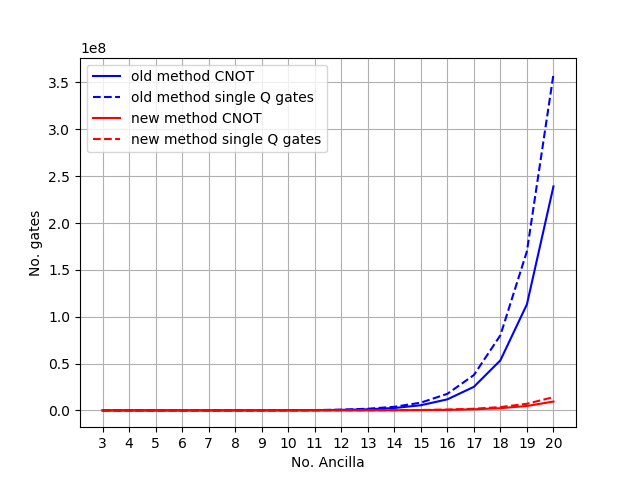

In [382]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(N_ancilla, old_CNOT, color='b', label='old method CNOT')
ax.plot(N_ancilla, old_single_G, color='b', label='old method single Q gates', linestyle='--')

ax.plot(N_ancilla, new_CNOT, color='r', label='new method CNOT')
ax.plot(N_ancilla, new_single_G, color='r', label='new method single Q gates', linestyle='--')

ax.set(xlabel='No. Ancilla', ylabel='No. gates')
#                                         ,title='Scaling of methods')

ax.set_xticks(N_ancilla)

ax.grid()
plt.legend()

In [383]:
# def reduction(n_ancilla_qubits):
    
#     state_array = np.arange(0,2**n_ancilla_qubits,1)
#     grey_state_array =np.array([int_to_Gray(i, n_ancilla_qubits) for i in state_array])
    

#     for state_1_index, state_1 in enumerate(grey_state_array[:-1]):
#         state_2=grey_state_array[state_1_index+1]
        
#         if state_1[0] == state_2[0]:
#             n_common_bits=0
#             for bit_1_index, state_1_bit in enumerate(state_1[1:]):
#                 state_2_bit = state_2[1:][bit_1_index]
#                 if state_1_bit==state_2_bit:
#                     n_common_bits+=1
#                 else:
#                     break
                    
#             if n_common_bits==0:
#                 ## c-T*c-T = X
#                 num_T_removed=2
#                 num_X_added=1
            
#                 # TXT = XT
#                 num_T_removed+=1
                
#             elif n_common_bits==n_ancilla_qubits-2:
#                 # TT = I
#                 num_T_removed=2*n_common_bits
                
#                 # c-T c-T = X
#                 num_T_removed+=2
#                 num_X_added=1
                
#             else:
#                 # TT = I
#                 num_T_removed=2*n_common_bits
                
#                 # c-T c-T = X
#                 num_T_removed+=2
#                 num_X_added=1
                
#                 # TXT = XT
#                 num_T_removed+=1
                
                
#         else:
#             ## c-T*c-T = X
#             num_T_removed=2
#             num_X_added=1
            
#             # TXT = XT
#             num_T_removed+=1
        
#         print(state_1, ' vs ', state_2)
#         if (state_1[0] == state_2[0]) and (n_common_bits!=n_ancilla_qubits-2):
#             print('No. common bits = ', n_common_bits)
#         print('T removed = ',num_T_removed)
#         print('X added   = ',num_X_added)
#         print('###')
#     return num_T_removed, num_X_added
        

# reduction(5)

In [ ]:
cirq.Circuit(cirq.X.controlled(num_controls=2,control_values= [1, 1]).on(qubits[1], qubits[2],  qubits[3]))

In [ ]:
qubits = list(cirq.LineQubit.range(4))
circuit = cirq.Circuit(
cirq.Circuit(cirq.X.controlled(num_controls=2,control_values= [1, 1]).on(qubits[1], qubits[2],  qubits[3])),
cirq.Circuit(cirq.X.controlled(num_controls=1,control_values= [0]).on(qubits[0], qubits[2])),
cirq.Circuit(cirq.X.controlled(num_controls=2,control_values= [1, 1]).on(qubits[1], qubits[2],  qubits[3])) 
)
circuit

In [ ]:
qubits = list(cirq.LineQubit.range(4))
circuit2 = cirq.Circuit(
cirq.Circuit(cirq.X.controlled(num_controls=1,control_values= [0]).on(qubits[0], qubits[2])),
cirq.Circuit(cirq.X.controlled(num_controls=2,control_values= [0, 1]).on(qubits[0], qubits[1],  qubits[3])) 
)
circuit2

In [ ]:
np.array_equal(circuit.unitary(), circuit2.unitary())

In [ ]:
qubits = list(cirq.LineQubit.range(4))
circuit = cirq.Circuit(
cirq.Circuit(cirq.X.controlled(num_controls=3, control_values=[0,0,0]).on(qubits[0],qubits[1],qubits[2],qubits[3])),
cirq.Circuit(cirq.X.controlled(num_controls=3, control_values=[1,0,0]).on(qubits[0],qubits[1],qubits[2],qubits[3])),
cirq.Circuit(cirq.X.controlled(num_controls=3, control_values=[1,1,0]).on(qubits[0],qubits[1],qubits[2],qubits[3])),
cirq.Circuit(cirq.X.controlled(num_controls=3, control_values=[0,1,0]).on(qubits[0],qubits[1],qubits[2],qubits[3])),
cirq.Circuit(cirq.X.controlled(num_controls=3, control_values=[0,1,1]).on(qubits[0],qubits[1],qubits[2],qubits[3])),
cirq.Circuit(cirq.X.controlled(num_controls=3, control_values=[1,1,1]).on(qubits[0],qubits[1],qubits[2],qubits[3])),
cirq.Circuit(cirq.X.controlled(num_controls=3, control_values=[1,0,1]).on(qubits[0],qubits[1],qubits[2],qubits[3])),
cirq.Circuit(cirq.X.controlled(num_controls=3, control_values=[0,0,1]).on(qubits[0],qubits[1],qubits[2],qubits[3])),
)
circuit

In [ ]:
qubits = list(cirq.LineQubit.range(4))
circuit2 = cirq.Circuit(
    cirq.I.on(qubits[0]),
    cirq.I.on(qubits[1]),
    cirq.I.on(qubits[2]),
    cirq.X.on(qubits[3]),)
circuit2

In [ ]:
np.array_equal(circuit.unitary(), circuit2.unitary())

In [ ]:
qubits = list(cirq.LineQubit.range(4))
circuit = cirq.Circuit(
cirq.Circuit(cirq.X.controlled(num_controls=3, control_values=[0,0,0]).on(qubits[0],qubits[1],qubits[2],qubits[3])),
cirq.Circuit(cirq.X.controlled(num_controls=3, control_values=[1,0,0]).on(qubits[0],qubits[1],qubits[2],qubits[3]))
)
circuit

In [ ]:
qubits = list(cirq.LineQubit.range(4))
circuit2 = cirq.Circuit(
cirq.I.on(qubits[0]),
cirq.Circuit(cirq.X.controlled(num_controls=2, control_values=[0,0]).on(qubits[1],qubits[2],qubits[3])),
)
circuit2

In [ ]:
np.array_equal(circuit.unitary(), circuit2.unitary())

## cannot do

In [67]:
from openfermion.ops import QubitOperator

In [ ]:
QubitOperator('X0')*QubitOperator('Y0')

In [ ]:
class phase_Pauli_gate(cirq.SingleQubitGate):
    """
    Description

    Args:
        theta (float): angle to rotate by in radians.
        number_control_qubits (int): number of control qubits
    """

    def __init__(self, phase, pauli_str):
        self.phase = phase
        self.pauli_str = pauli_str

    def _unitary_(self):
        if self.pauli_str == 'X':
            return cirq.X._unitary_()*self.phase
        elif self.pauli_str == 'Y':
            return cirq.Y._unitary_()*self.phase
        elif self.pauli_str == 'Z':
            return cirq.Z._unitary_()*self.phase
        elif self.pauli_str == 'I':
            return cirq.I._unitary_()*self.phase
        else:
            raise ValueError('Not a Pauli operation')

    def num_qubits(self):
        return 1

    def _circuit_diagram_info_(self, args):
        return str(self.phase) +'*'+self.pauli_str

    def __str__(self):
        return str(self.phase) +'*'+self.pauli_str

    def __repr__(self):
        return self.__str__()

In [ ]:
QubitOperator('Y0',-1)*QubitOperator('Z0', 1j)

In [ ]:
qubits = list(cirq.LineQubit.range(4))
circuit = cirq.Circuit(
cirq.Circuit(cirq.X.controlled(num_controls=3, control_values=[0,0,0]).on(qubits[0],qubits[1],qubits[2],qubits[3])),
cirq.Circuit(cirq.Y.controlled(num_controls=3, control_values=[1,0,0]).on(qubits[0],qubits[1],qubits[2],qubits[3]))
)
circuit

In [ ]:
phase_Z0_gate = phase_Pauli_gate(1j, 'Z')
phase_Y_gate = phase_Pauli_gate(-1, 'Y')

qubits = list(cirq.LineQubit.range(4))
circuit2 = cirq.Circuit(
#     cirq.Circuit(phase_Y_gate.controlled(num_controls=1, control_values=[0]).on(qubits[0],qubits[3])),
#     cirq.Circuit(cirq.X.controlled(num_controls=1, control_values=[1]).on(qubits[0],qubits[3])),
    cirq.I.on(qubits[0]),
    cirq.Circuit(phase_Z0_gate.controlled(num_controls=2, control_values=[0,0]).on(qubits[1],qubits[2],qubits[3])),
)
circuit2

In [ ]:
np.array_equal(circuit.unitary(), circuit2.unitary())

In [93]:
OP1=QubitOperator('X0 I1',1)+QubitOperator('X0 Y1',1)

OP2=QubitOperator('Z0 Z1',1)+QubitOperator('Y0 X1',1)

In [94]:
OP1*OP2==OP2*OP1

False

In [85]:
OP1=QubitOperator('X0 X1',1)+QubitOperator('Z0 Z1',1)

OP2=QubitOperator('Y0 Y1',1)
OP1*OP2==OP2*OP1

True

In [202]:
OP1=QubitOperator('Y0',1)

OP2=QubitOperator('X0',1)
OP1*OP2

-1j [Z0]

In [203]:
1j*1j*-1j

1j